In [213]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv, ast, psycopg2
import os
import sqlite3
import gzip
import seaborn as sns
import matplotlib.pyplot as plt
import json 
from chart_studio.plotly import iplot
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import statistics

from sqlite3 import Error
from collections import Counter

def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql(query_sql):

    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows = pd.DataFrame(c.fetchall())
    return rows


In [2]:
df = pd.read_csv('survey_results_public.csv')
df.head()

/home/mavericku/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.



,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,...,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
0,1,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,...,3 - 4 times per week,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy
1,3,Yes,Yes,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,...,Daily or almost every day,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",White or of European descent,35 - 44 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy
2,4,Yes,Yes,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,...,I don't typically exercise,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,35 - 44 years old,No,No,The survey was an appropriate length,Somewhat easy
4,7,Yes,No,South Africa,"Yes, part-time",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,...,3 - 4 times per week,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,18 - 24 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy


## AUTOMATE TABLE CREATION

We first input the files in to the Database

In [3]:
## Determining data type
def determine_data_type_of_list(values):  
    if type(values) == list:
        do_float = 0
        do_string = 0
        do_int = 0
        for x in values: 
            #print(x)
            try: 
                test_x_float = float(x) 
                try:
                    test_x_int = int(x) 
                except:
                    test_x_int = float(x)
                    do_float += 1 
                if int(test_x_float) == test_x_int:  
                    do_int +=1
                else:
                    do_float +=1 
            except:              
                do_string +=1
                 
        if do_string >0: 
            return str
        elif do_float > 0 : 
            return float
        else : 
            return int 
    else:
        return determine_data_type(values)

In [4]:
all_columns = [] 
main_table = "stack_overflow_survey"

In [5]:
statement = 'create table if not exists ' + main_table  + ' (' 
for column in df.columns.values:
    all_columns.append(column)
    column_data_type = determine_data_type_of_list(df[column].tolist())
#     print(column_data_type)
    if column_data_type == str: 
        statement = (statement + '\n{} text,').format(column.lower() )
    elif column == "Respondent":
        
        statement = (statement + '\n{} int not null primary key,').format(column.lower() )
    else:
        statement = (statement + '\n' + '{} {}' + ',').format(column.lower(), "int") 
statement = statement[:-1] + ');' 

In [6]:
#CREATE TABLES
create_table_sql = statement
sql_table_name = "Stack_Over_Flow_Survey.db"
conn = create_connection(sql_table_name) 
create_table(conn , create_table_sql)

In [7]:
insert_sql = """INSERT INTO stack_overflow_survey (respondent, hobby, opensource, country, student, employment, formaleducation, undergradmajor, companysize, devtype, yearscoding, yearscodingprof, jobsatisfaction, careersatisfaction, hopefiveyears, jobsearchstatus, lastnewjob, assessjob1, assessjob2, assessjob3, assessjob4, assessjob5, assessjob6, assessjob7, assessjob8, assessjob9, assessjob10, assessbenefits1, assessbenefits2, assessbenefits3, assessbenefits4, assessbenefits5, assessbenefits6, assessbenefits7, assessbenefits8, assessbenefits9, assessbenefits10, assessbenefits11, jobcontactpriorities1, jobcontactpriorities2, jobcontactpriorities3, jobcontactpriorities4, jobcontactpriorities5, jobemailpriorities1, jobemailpriorities2, jobemailpriorities3, jobemailpriorities4, jobemailpriorities5, jobemailpriorities6, jobemailpriorities7, updatecv, currency, salary, salarytype, convertedsalary, currencysymbol, communicationtools, timefullyproductive, educationtypes, selftaughttypes, timeafterbootcamp, hackathonreasons, agreedisagree1, agreedisagree2, agreedisagree3, languageworkedwith, languagedesirenextyear, databaseworkedwith, databasedesirenextyear, platformworkedwith, platformdesirenextyear, frameworkworkedwith, frameworkdesirenextyear, ide, operatingsystem, numbermonitors, methodology, versioncontrol, checkincode, adblocker, adblockerdisable, adblockerreasons, adsagreedisagree1, adsagreedisagree2, adsagreedisagree3, adsactions, adspriorities1, adspriorities2, adspriorities3, adspriorities4, adspriorities5, adspriorities6, adspriorities7, aidangerous, aiinteresting, airesponsible, aifuture, ethicschoice, ethicsreport, ethicsresponsible, ethicalimplications, stackoverflowrecommend, stackoverflowvisit, stackoverflowhasaccount, stackoverflowparticipate, stackoverflowjobs, stackoverflowdevstory, stackoverflowjobsrecommend, stackoverflowconsidermember, hypotheticaltools1, hypotheticaltools2, hypotheticaltools3, hypotheticaltools4, hypotheticaltools5, waketime, hourscomputer, hoursoutside, skipmeals, ergonomicdevices, exercise, gender, sexualorientation, educationparents, raceethnicity, age, dependents, militaryus, surveytoolong, surveyeasy) 
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
"""
# # print(statement)
# print(len(all_columns))

# for i in range(0 , 129):
#     print("?, ", end = "")

In [8]:
# print(insert_sql)

In [9]:
# INSERT FUNCTION
def insert_rows_to_db(conn, data_tuple): 
    try:
        c = conn.cursor()
        c.executemany(insert_sql, data_tuple)
        conn.commit()
    except Error as e:  
        print(e)

In [10]:
# EXTRACT DATA
index_print_times = 0
test_times = 30
all_respondet_answer_tuple = []
for index, value in  df.iterrows(): 
    respondent_answer_tuple = [] 
    for columns in all_columns: 
        respondent_answer_tuple.append(value[columns])
        index_print_times += 1  
#     insert_rows_to_db(conn, tuple(respondent_answer_tuple))
    all_respondet_answer_tuple.append(tuple(respondent_answer_tuple)) 
    
############### IF ERROR, DELETE .DB FILE THEN RERUN #########################

In [11]:
# INSERT TO DB
insert_rows_to_db(conn, all_respondet_answer_tuple)

UNIQUE constraint failed: stack_overflow_survey.respondent


# First, we analyze our users

We first take a look at the respondents that have taken the survey
We wish to know
1. The amount of respondents from each of the countries
2. The male/female ratio
3. The age group of respondents
4. How many code as a hobby
5. The typical degree type and major
6. Type of developer

In [12]:
select_sql = "SELECT ? "
select_from_table = "FROM " + main_table
select_columns = ["Respondent", "Hobby" , "OpenSource" , "Country" , "Student" , "Employment" , 
                  "FormalEducation" , "UndergradMajor" , "CompanySize" , "DevType" , "YearsCoding" ,
                  "YearsCodingProf" , "JobSatisfaction" , "CareerSatisfaction" , "HopeFiveYears" , "JobSearchStatus" , 
                  "LastNewJob" ,"Age" , "MilitaryUS" , "RaceEthnicity" , "EducationParents" , "Gender" ,"WakeTime" ,
                  "HoursComputer" , "HoursOutside" , "SkipMeals" , "ErgonomicDevices"]

In [13]:
select_column_whole = " "
for column in select_columns:
    select_column_whole = select_column_whole + column + " ,"
select_column_whole = select_column_whole[:-1] 
select_sql = select_sql.replace("?" , select_column_whole, 1) + select_from_table 

In [14]:
c = conn.cursor()
c.execute(select_sql)
conn.commit()

In [15]:
select_respondent_reponse = c.fetchall()
selected_response = pd.DataFrame(select_respondent_reponse , columns = select_columns)
selected_response = selected_response.set_index('Respondent')

In [16]:
selected_response.head()

,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,YearsCoding,...,Age,MilitaryUS,RaceEthnicity,EducationParents,Gender,WakeTime,HoursComputer,HoursOutside,SkipMeals,ErgonomicDevices
Respondent,,,,,,,,,,,,,,,,,,,,,
1,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,3-5 years,...,25 - 34 years old,None,Black or of African descent,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Male,Between 5:00 - 6:00 AM,9 - 12 hours,1 - 2 hours,Never,Standing desk
3,Yes,Yes,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,30 or more years,...,35 - 44 years old,None,White or of European descent,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Male,Between 6:01 - 7:00 AM,5 - 8 hours,30 - 59 minutes,Never,Ergonomic keyboard or mouse
4,Yes,Yes,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,24-26 years,...,None,None,None,None,None,None,None,None,None,None
5,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,18-20 years,...,35 - 44 years old,No,White or of European descent,Some college/university study without earning ...,Male,Between 6:01 - 7:00 AM,9 - 12 hours,Less than 30 minutes,3 - 4 times per week,None
7,Yes,No,South Africa,"Yes, part-time",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,6-8 years,...,18 - 24 years old,None,White or of European descent,Some college/university study without earning ...,Male,Before 5:00 AM,Over 12 hours,1 - 2 hours,Never,None


## Developers from around the country

In [17]:
# DEVELOPERS FROM AROUND THE COUNTRY
country_responses = set(selected_response["Country"])
total_appearance_of_each_country = Counter(selected_response["Country"])

# print(len(country_responses))
# print(total_appearance_of_each_country)
# Counter({'United States': 20309, 'India': 13721, 'Germany': 6459, 'United Kingdom': 6221, 'Canada': 3393, 'Russian Federation': 2869, 'France': 2572, 'Brazil': 2505, 'Poland': 2122, 'Australia': 2018, 'Netherlands': 1841, 'Spain': 1769, 'Italy': 1535, 'Ukraine': 1279, 'Sweden': 1164, 'Pakistan': 1050, 'China': 1037, 'Switzerland': 1010, 'Turkey': 1004, 'Israel': 1003, 'Iran, Islamic Republic of...': 921, 'Romania': 793, 'Austria': 788, 'Czech Republic': 784, 'Belgium': 743, 'Mexico': 736, 'Bangladesh': 697, 'Denmark': 653, 'South Africa': 637, 'Indonesia': 630, 'Argentina': 611, 'Norway': 565, 'New Zealand': 557, 'Ireland': 554, 'Portugal': 528, 'Finland': 521, 'Philippines': 520, 'Greece': 516, 'Hungary': 470, 'Sri Lanka': 454, 'Bulgaria': 425, 'Egypt': 419, None: 412, 'Nigeria': 399, 'Singapore': 376, 'Malaysia': 363, 'Japan': 361, 'Serbia': 358, 'Colombia': 339, 'Belarus': 339, 'Viet Nam': 331, 'Nepal': 295, 'Lithuania': 257, 'Croatia': 241, 'Chile': 238, 'Slovakia': 238, 'Slovenia': 238, 'Hong Kong (S.A.R.)': 219, 'Thailand': 213, 'Morocco': 213, 'Taiwan': 207, 'Kenya': 194, 'United Arab Emirates': 193, 'Estonia': 189, 'South Korea': 169, 'Tunisia': 163, 'Latvia': 145, 'Algeria': 130, 'Saudi Arabia': 130, 'Peru': 128, 'Bosnia and Herzegovina': 125, 'Venezuela, Bolivarian Republic of...': 123, 'Armenia': 117, 'Dominican Republic': 115, 'Albania': 109, 'Lebanon': 107, 'Kazakhstan': 107, 'Uruguay': 102, 'Costa Rica': 98, 'Other Country (Not Listed Above)': 84, 'Jordan': 83, 'Azerbaijan': 78, 'Ghana': 76, 'Republic of Moldova': 76, 'Georgia': 75, 'Uganda': 67, 'Malta': 66, 'Cuba': 65, 'Ecuador': 65, 'Afghanistan': 64, 'Republic of Korea': 62, 'Cambodia': 60, 'Ethiopia': 60, 'Luxembourg': 59, 'Uzbekistan': 56, 'Syrian Arab Republic': 56, 'Myanmar': 55, 'The former Yugoslav Republic of Macedonia': 54, 'Guatemala': 50, 'Paraguay': 49, 'United Republic of Tanzania': 49, 'Cyprus': 49, 'El Salvador': 46, 'Iceland': 45, 'Bolivia': 44, 'Iraq': 42, 'Zimbabwe': 39, 'Mauritius': 35, 'Cameroon': 34, 'Panama': 32, 'Nicaragua': 31, 'Honduras': 25, 'Sudan': 25, 'Qatar': 23, 'Kuwait': 23, 'Kyrgyzstan': 22, 'Mozambique': 21, 'Mongolia': 21, 'Oman': 20, 'Jamaica': 20, 'Trinidad and Tobago': 20, 'Madagascar': 19, 'Rwanda': 18, 'Bahrain': 16, 'Montenegro': 15, 'Andorra': 15, 'Libyan Arab Jamahiriya': 14, 'Yemen': 13, 'Senegal': 13, 'Angola': 11, 'Somalia': 10, 'Maldives': 10, 'Benin': 10, 'Antigua and Barbuda': 9, 'Malawi': 9, 'Zambia': 9, 'Fiji': 8, 'Haiti': 8, 'Democratic Republic of the Congo': 7, "Côte d'Ivoire": 7, 'Bhutan': 6, 'Turkmenistan': 6, 'Namibia': 6, 'Bahamas': 6, 'Congo, Republic of the...': 6, 'Liechtenstein': 5, 'Gabon': 5, 'Gambia': 5, 'Togo': 5, 'Burkina Faso': 5, 'Botswana': 4, 'Barbados': 4, 'Tajikistan': 4, 'Monaco': 4, 'North Korea': 4, 'Swaziland': 3, 'Guinea': 3, 'Mauritania': 3, 'Liberia': 3, 'Cape Verde': 3, 'Micronesia, Federated States of...': 2, 'Lesotho': 2, 'Marshall Islands': 2, 'Central African Republic': 2, 'Palau': 2, 'Suriname': 2, 'Dominica': 2, 'Niger': 2, 'Guyana': 2, "Democratic People's Republic of Korea": 2, 'San Marino': 1, 'Burundi': 1, 'Sierra Leone': 1, 'Grenada': 1, 'Belize': 1, 'Timor-Leste': 1, 'Solomon Islands': 1, 'Saint Lucia': 1, 'Nauru': 1, 'Mali': 1, 'Brunei Darussalam': 1, 'Eritrea': 1, 'Djibouti': 1, 'Guinea-Bissau': 1})

In [18]:

# # Calculate the Mean
# total_num = 0
# for items in total_appearance_of_each_country.items():
#     total_num += items[1]
# print(total_num / (len(total_appearance_of_each_country.items())))
 

In [19]:
selected_10_countries = selected_response["Country"].dropna().value_counts().head(20)   
print(selected_10_countries)

United States         20309
India                 13721
Germany                6459
United Kingdom         6221
Canada                 3393
Russian Federation     2869
France                 2572
Brazil                 2505
Poland                 2122
Australia              2018
Netherlands            1841
Spain                  1769
Italy                  1535
Ukraine                1279
Sweden                 1164
Pakistan               1050
China                  1037
Switzerland            1010
Turkey                 1004
Israel                 1003
Name: Country, dtype: int64


In [20]:
country_label = []
country_count = []
for i in selected_10_countries:
    country_label.append(selected_10_countries[selected_10_countries == i ].index[0])
    country_count.append(i)

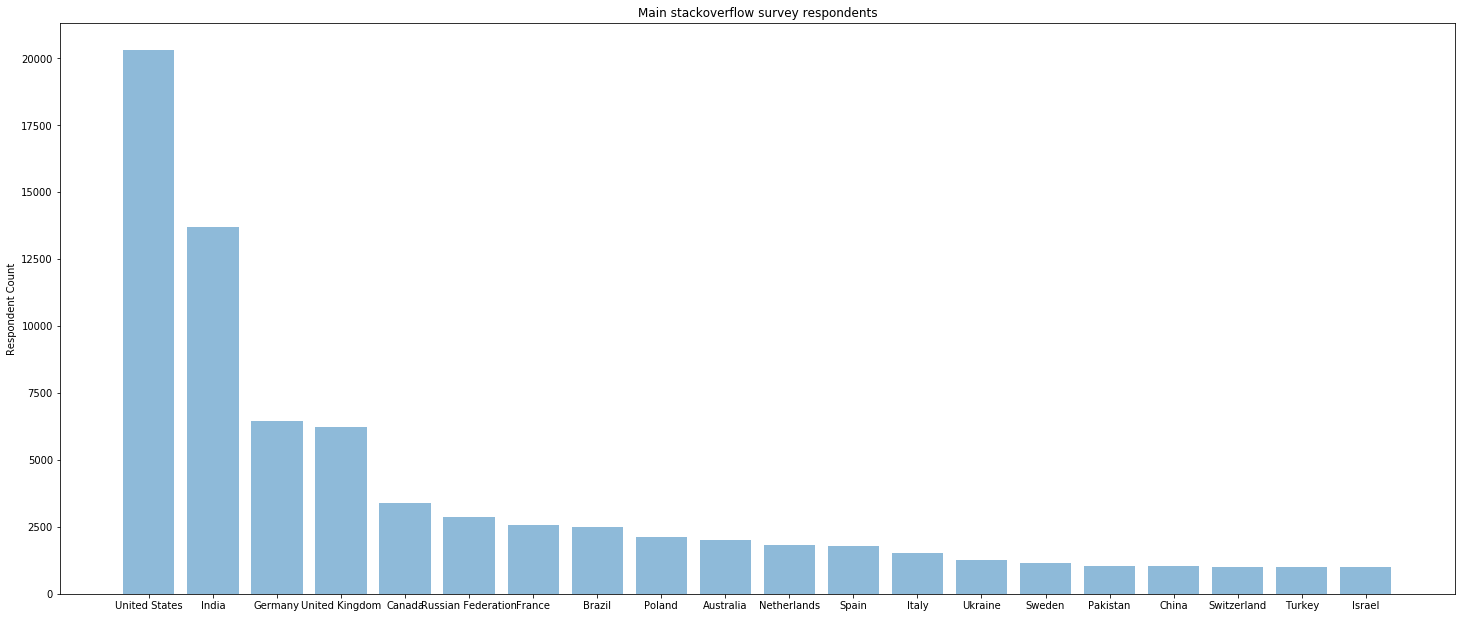

In [21]:
plt.bar(country_label, country_count, align='center', alpha=0.5)
plt.xticks(country_label)
plt.ylabel('Respondent Count')
plt.title('Main stackoverflow survey respondents')

plt.savefig("./Figure/CountryRespondents.png")
fig = plt.gcf()
fig.set_size_inches(25, 10.5)
plt.show()

In [22]:
country_label

['United States',
 'India',
 'Germany',
 'United Kingdom',
 'Canada',
 'Russian Federation',
 'France',
 'Brazil',
 'Poland',
 'Australia',
 'Netherlands',
 'Spain',
 'Italy',
 'Ukraine',
 'Sweden',
 'Pakistan',
 'China',
 'Switzerland',
 'Turkey',
 'Israel']

### Out of the 98,855 respondents, there were developers from 184 countries involved!
Out of the 184 countries the top contributing countries are
['United States',
 'India',
 'Germany',
 'United Kingdom',
 'Canada',
 'Russian Federation',
 'France',
 'Brazil',
 'Poland',
 'Australia',
 'Netherlands',
 'Spain',
 'Italy',
 'Ukraine',
 'Sweden',
 'Pakistan',
 'China',
 'Switzerland',
 'Turkey',
 'Israel']

---
## Now we check out the gender ratio

In [23]:
gender_responses = selected_response["Gender"]
# print(gender_responses)
total_gender_responses = []
for i in gender_responses: 
    if i != None:
        i = i.split(";") 
        if type(i) == list:
            for q in i :
                total_gender_responses.append(q)
        else:
            total_gender_responses.append(i)
        
        
set_gender_response = set(total_gender_responses)
print(set_gender_response)
# print(json.dumps(gender_set_responses , indent = 4))
# total_appearance_of_each_country = Counter(selected_response["Country"])

{'Non-binary, genderqueer, or gender non-conforming', 'Transgender', 'Male', 'Female'}


In [24]:
gender_dict = {}
gender_dict["Male"] = 0
gender_dict["Female"] = 0 
gender_dict["Others"] = 0
gender_dict["Undisclosed"] = 0
for i in selected_response["Gender"]:
#     print(i) 
    if i is None: 
        gender_dict["Undisclosed"] +=1 
    elif "Male" in i:
        gender_dict["Male"] += 1
    elif "Female" in i :
        gender_dict["Female"] +=1 
    else:
        gender_dict["Others"] +=1 
    

In [25]:
gender_count = []
gender_count.append(gender_dict["Male"])
gender_count.append(gender_dict["Female"])
gender_count.append(gender_dict["Undisclosed"])
gender_count.append(gender_dict["Others"])
gender_label = "Male" , "Female" , "Undisclosed" , "Others"

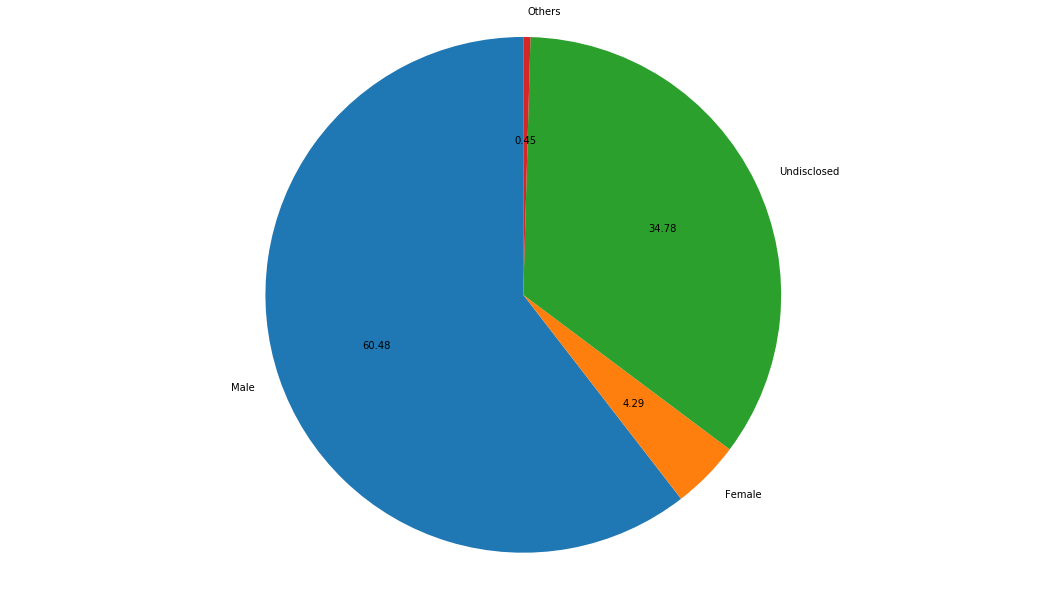

In [26]:
# GRAPHING GENDER
figureObject, axesObject = plt.subplots() 

plt.pie(gender_count,
        labels=gender_label, 
        autopct='%1.2f', 
        startangle=90) 

plt.axis('equal')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.savefig("./Figure/GenderPlot.png")

plt.show()

---
## Now we visualize the age groups

In [27]:
age_responses = selected_response["Age"]

In [28]:
age_responses.unique()

array(['25 - 34 years old', '35 - 44 years old', None,
       '18 - 24 years old', '45 - 54 years old', '55 - 64 years old',
       'Under 18 years old', '65 years or older'], dtype=object)

In [29]:
age_responses = selected_response.groupby("Age").nunique()

In [30]:
age_responses = selected_response.Age.value_counts()

In [31]:
age_label = []
age_value = []
for i in age_responses:
#     print*()
    age_label.append(age_responses[age_responses == i].index[0])
    age_value.append(i)

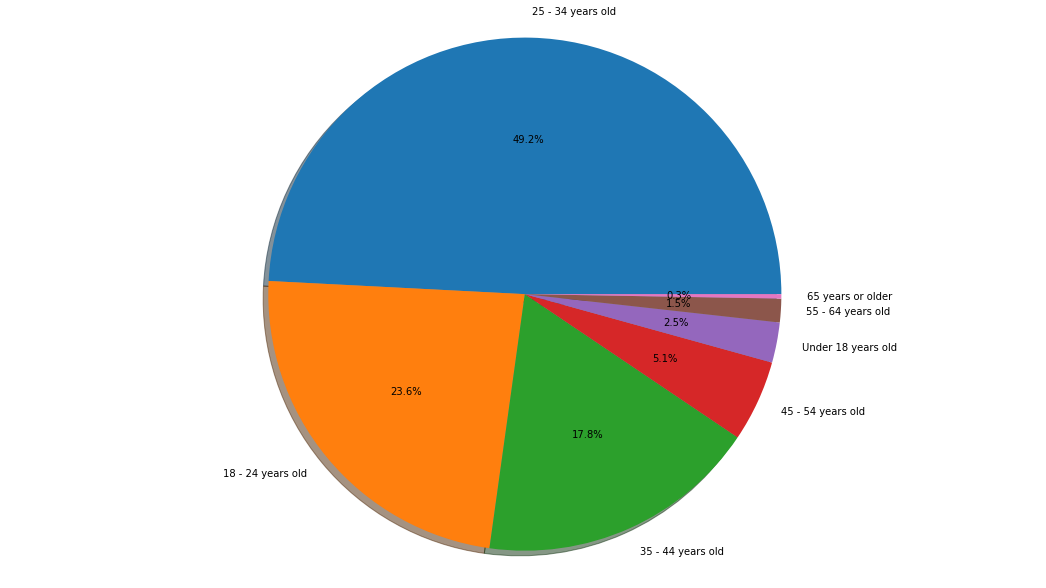

In [32]:
fig1, ax1 = plt.subplots()
ax1.pie(age_value, labels=age_label, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig("./Figure/age_pie")
plt.show()

---
## Visualize contribution to open source

In [33]:
open_source_response = selected_response["OpenSource"]

In [34]:
open_source_count_unique = selected_response.OpenSource.value_counts()

In [35]:
open_source_label = []
open_source_count_total = []
for i in open_source_count_unique: 
    open_source_label.append(open_source_count_unique[open_source_count_unique == i ].index[0])
    open_source_count_total.append(i)

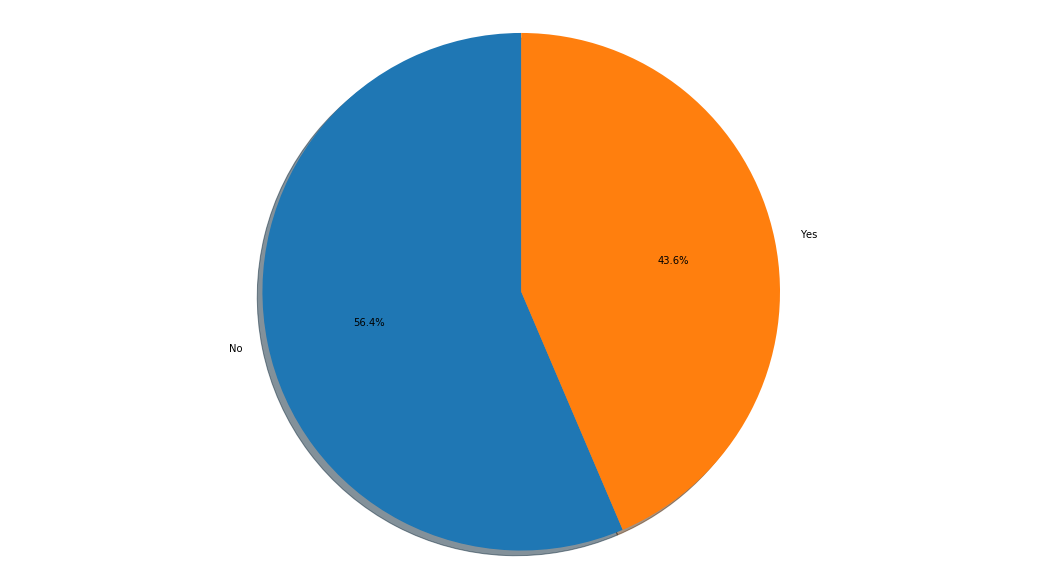

In [36]:
fig1, ax1 = plt.subplots()
ax1.pie(open_source_count_total, labels=open_source_label, autopct='%1.1f%%', shadow=True,
        startangle=90)
ax1.axis('equal')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig("./Figure/open_source")
plt.show()

---
## Now we try to look at the types of job we get for each age group

In [37]:
# jobs_to_year_dev = selected_response[["DevType" , "YearsCoding"]]

In [38]:
# jobs_to_year_dev

In [39]:
# jobs_to_year_dev.YearsCoding.unique()

In [40]:
# jobs_to_years_series = jobs_to_year_dev.YearsCoding.value_counts()

In [41]:
# jobs_to_years_dict = {} 
# for i in jobs_to_years_series: 
#     jobs_to_years_dict[str(jobs_to_years_series[jobs_to_years_series == i ].index[0])] = i 
# jobs_to_years_dict_keys = jobs_to_years_dict.keys()
# jobs_to_years_dict_value = jobs_to_years_dict.values()

In [42]:
# group_jobs_to_year_dev = jobs_to_year_dev.groupby("DevType")

In [43]:
# group_jobs_to_year_dev.first()

In [44]:
# group_jobs_to_year_dev.get_group("Back-end developer")

Empty devtype responses 6757

In [45]:
def query_year_and_dev():
    query_sql = "SELECT YearsCoding, DevType from " + main_table + " WHERE DevType is not null"
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall()
    return rows


In [46]:
years_coding_and_dev_type = pd.DataFrame(query_year_and_dev(), columns = ["YearsCoding" , "DevType"])
years_coding_and_dev_type

,YearsCoding,DevType
0,3-5 years,Full-stack developer
1,30 or more years,Database administrator;DevOps specialist;Full-...
2,24-26 years,Engineering manager;Full-stack developer
3,18-20 years,Full-stack developer
4,6-8 years,Data or business analyst;Desktop or enterprise...
...,...,...
92093,0-2 years,Data or business analyst
92094,30 or more years,Designer
92095,0-2 years,Back-end developer;QA or test developer;Student
92096,3-5 years,Back-end developer;Designer;Student


In [47]:
# Split options and find specific options
def find_set_dev_type():
    unique_list = []
    null_list_dev_type = []
    for i in years_coding_and_dev_type.DevType:
        if i is not None:
            split_list = i.split(";") 
            for i in split_list:
                unique_list.append(i)
        else :
            null_list_dev_type.append(i) 
    return set(unique_list)
    

In [48]:
find_set_dev_type()

{'Back-end developer',
 'C-suite executive (CEO, CTO, etc.)',
 'Data or business analyst',
 'Data scientist or machine learning specialist',
 'Database administrator',
 'Designer',
 'Desktop or enterprise applications developer',
 'DevOps specialist',
 'Educator or academic researcher',
 'Embedded applications or devices developer',
 'Engineering manager',
 'Front-end developer',
 'Full-stack developer',
 'Game or graphics developer',
 'Marketing or sales professional',
 'Mobile developer',
 'Product manager',
 'QA or test developer',
 'Student',
 'System administrator'}

# DATA SCIENTIST
{
 'Data or business analyst',
 'Data scientist or machine learning specialist',
 }

# Software Developers
{'Back-end developer',  
 'Database administrator', 
 'Desktop or enterprise applications developer',
 'DevOps specialist', 
 'Embedded applications or devices developer',
 'Engineering manager',
 'Front-end developer',
 'Full-stack developer',
 'Game or graphics developer', 
 'Mobile developer', 
 'QA or test developer', 
 'System administrator'}

In [49]:
data_science_position_titles = {
 'Data or business analyst',
 'Data scientist or machine learning specialist',
 } 

In [50]:
def find_year_and_dev_by_DevType():
    found_data_scientist = []
    coding_years_set = []
    for individual_position_block in years_coding_and_dev_type.values:
        
        this_man_is_a_data_scientist = False
        if individual_position_block[1] is not None:
            individual_position_block_list = individual_position_block[1].split(";")
            for indi_positions in individual_position_block_list:
                if indi_positions in data_science_position_titles:
                    this_man_is_a_data_scientist = True
        if this_man_is_a_data_scientist == True:
            found_data_scientist.append(individual_position_block)
            coding_years_set.append(individual_position_block[0])
    coding_years_set = set(coding_years_set)
    return found_data_scientist, coding_years_set


found_years_devtype_ds , coding_years_set = find_year_and_dev_by_DevType() 

In [51]:
def count_total_ds_in_age_group():
    total_ds_in_age_group = {}
    for i in range(0 , len(found_years_devtype_ds)): 
        try:
            total_ds_in_age_group[found_years_devtype_ds[i][0]] += 1
        except:
            total_ds_in_age_group[found_years_devtype_ds[i][0]] = 1
    return total_ds_in_age_group
total_ds_in_age_group = count_total_ds_in_age_group()

In [52]:
# Sort in Age Order
total_ds_in_age_group = { '0-2 years': 1071, '3-5 years': 2798,'6-8 years': 2482,'9-11 years': 1553, '12-14 years': 1071,  '15-17 years': 887,  '18-20 years': 785,'24-26 years': 334, '21-23 years': 425, '27-29 years': 174, '30 or more years': 721}

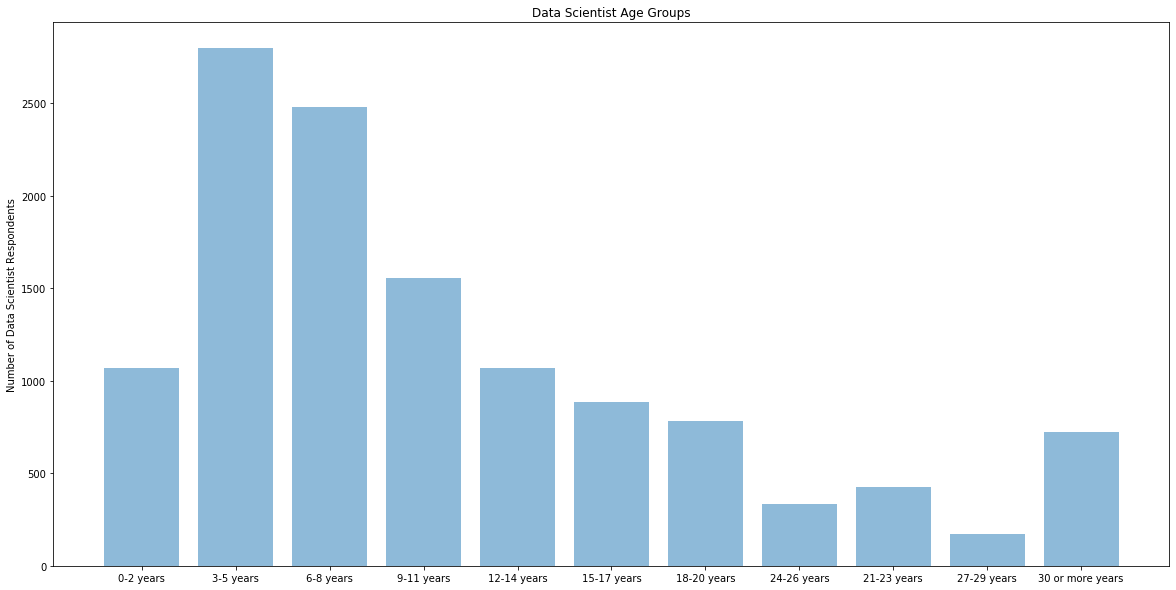

In [53]:
plt.bar(total_ds_in_age_group.keys(), total_ds_in_age_group.values(), align='center', alpha=0.5)
plt.ylabel('Number of Data Scientist Respondents')
plt.title('Data Scientist Age Groups')
fig = plt.gcf()
fig.set_size_inches(20, 10) 

plt.savefig("./Figure/Age_DataScientist.png")
plt.show()

---
## Formal Education


In [54]:
formal_education = selected_response[["FormalEducation" , "DevType"]]

In [55]:
cleaned_formal_education = []
for i in formal_education.values:
#     print(i)
#     break
    
    if i is not None and i[1] is not None and i[0] is not None: 
        #split multiple jobs positions
        dev_type = i[1].split(";")
        this_man_data_scientist = False
        for jobs in dev_type:
            if jobs in data_science_position_titles:
                this_man_data_scientist = True
        if this_man_data_scientist:
            cleaned_formal_education.append(i[0])
possible_education_credentials = set(cleaned_formal_education)

In [56]:
possible_education_credentials

{'Associate degree',
 'Bachelor’s degree (BA, BS, B.Eng., etc.)',
 'I never completed any formal education',
 'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
 'Other doctoral degree (Ph.D, Ed.D., etc.)',
 'Primary/elementary school',
 'Professional degree (JD, MD, etc.)',
 'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
 'Some college/university study without earning a degree'}

In [57]:
total_degree_for_ds = {}
for i in formal_education.values:
    if i is not None and i[1] is not None and i[0] is not None:
        try:
            total_degree_for_ds[i[0]] +=1
        except :
            total_degree_for_ds[i[0]]= 1

In [58]:
total_degree_for_ds

{'Bachelor’s degree (BA, BS, B.Eng., etc.)': 41848,
 'Associate degree': 2798,
 'Some college/university study without earning a degree': 11070,
 'Master’s degree (MA, MS, M.Eng., MBA, etc.)': 20399,
 'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 8510,
 'Primary/elementary school': 1545,
 'Professional degree (JD, MD, etc.)': 1318,
 'I never completed any formal education': 617,
 'Other doctoral degree (Ph.D, Ed.D., etc.)': 2056}

In [59]:
print_total_degree_keys = []
for i in total_degree_for_ds.keys():
    i = i.split(" " , 2) 
    print_total_degree_keys.append(i[0] + " " + i [1])

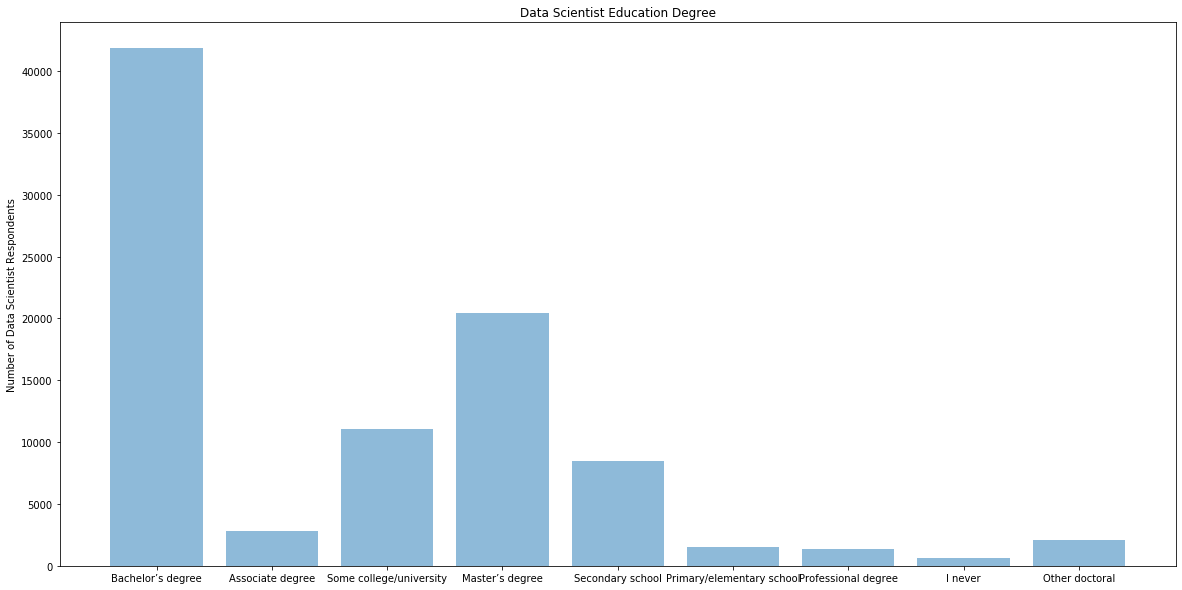

In [60]:
plt.bar(print_total_degree_keys, list(total_degree_for_ds.values()), align='center', alpha=0.5)
plt.ylabel('Number of Data Scientist Respondents')
plt.title('Data Scientist Education Degree')
fig = plt.gcf()
fig.set_size_inches(20, 10) 

plt.savefig("./Figure/Degree Data Scientist.png")
plt.show()

---
## Language Worked with
+ language desire next year
 

In [80]:
def query_languages_and_next_year():
    query_sql = "SELECT languageworkedwith, languagedesirenextyear from " + main_table + " WHERE languageworkedwith is not null OR languagedesirenextyear is not null"
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall()
    return rows
def query_languages_and_next_year_ds():
    query_sql = "SELECT languageworkedwith, languagedesirenextyear,devtype from " + main_table + " WHERE languageworkedwith is not null OR languagedesirenextyear is not null and devtype is not null"
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall()
    return rows
queried_language_and_next_year = pd.DataFrame(query_languages_and_next_year() , columns = ["LanguageWorkedWith" , "LanguagesNextYear"])
queried_language_and_next_year_ds = pd.DataFrame(query_languages_and_next_year_ds() , columns = ["LanguageWorkedWith" , "LanguagesNextYear", "DevType"])


In [81]:
def find_languages_total_count():
    languages_all_this = {}
    languages_all_next = {}
    for i in queried_language_and_next_year.values: 
        if i is not None and i[0] is not None and i[1] is not None: 
            current_list = i[0].split(";") 
            next_list = i[1].split(";")
            for languages_current in current_list:
                try:
                    languages_all_this[languages_current] +=1
                except:
                    languages_all_this[languages_current] = 1
            for languages_next in next_list:
                try:
                    languages_all_next[languages_next] +=1
                except:
                    languages_all_next[languages_next] = 1
    return languages_all_this, languages_all_next
languages_all_this , languages_all_next = find_languages_total_count()

In [82]:
def find_languages_total_count_ds():
    languages_all_this = {}
    languages_all_next = {}
    for i in queried_language_and_next_year_ds.values: 
        if i is not None and i[0] is not None and i[1] is not None and i[2] is not None:
            jobs_titles = i[2].split(";")  
            
            this_man_is_ds = False
            # Check if job is data scientist
            for job_indi in jobs_titles:
                if job_indi in data_science_position_titles:
                    this_man_is_ds = True
            if this_man_is_ds :
                current_list = i[0].split(";") 
                next_list = i[1].split(";")
                for languages_current in current_list:
                    try:
                        languages_all_this[languages_current] +=1
                    except:
                        languages_all_this[languages_current] = 1
                for languages_next in next_list:
                    try:
                        languages_all_next[languages_next] +=1
                    except:
                        languages_all_next[languages_next] = 1
    return languages_all_this, languages_all_next
languages_all_this_ds , languages_all_next_ds = find_languages_total_count_ds()

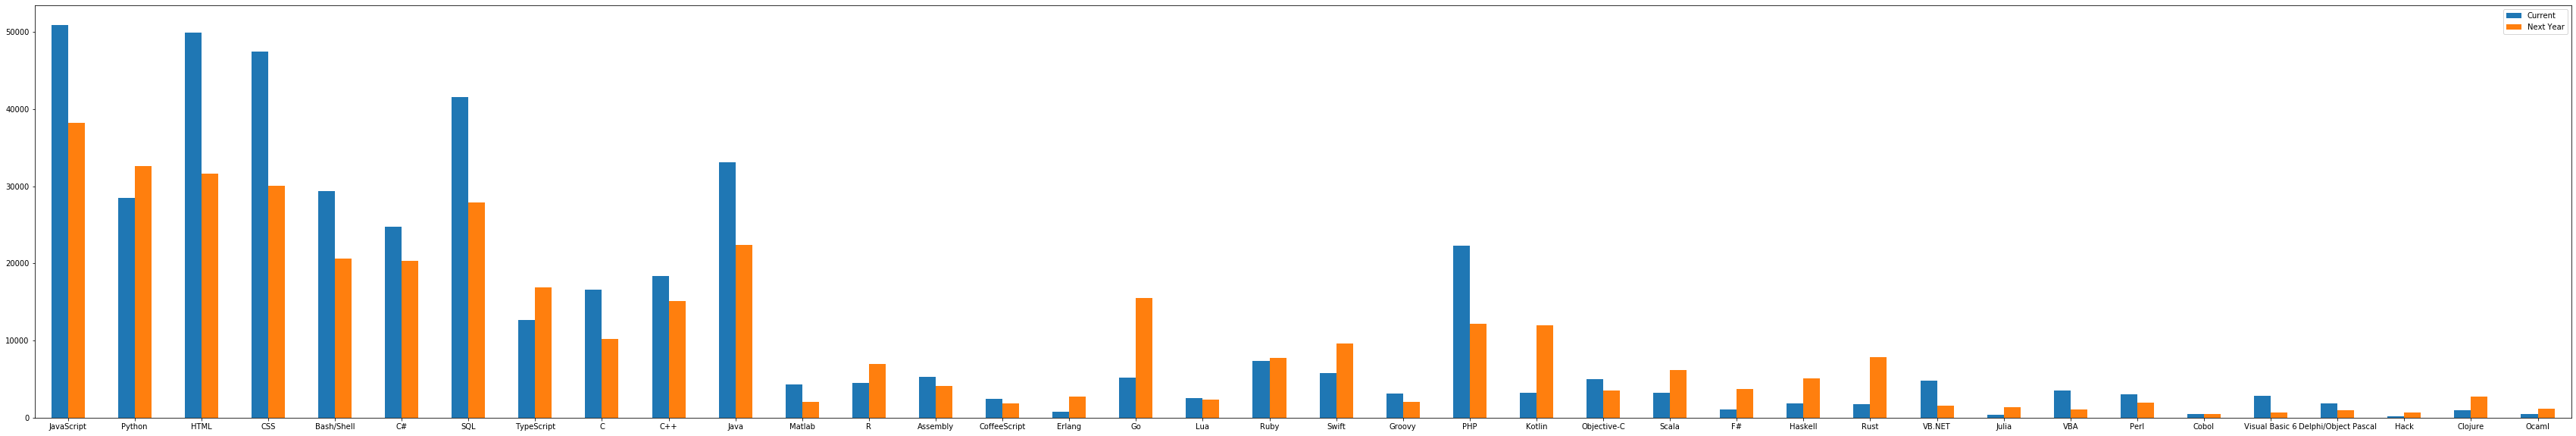

In [83]:
dict_languages_current_next = {"Current" : languages_all_this , "Next Year" : languages_all_next}
languages_dataframe = pd.DataFrame(dict_languages_current_next)
languages_plot = languages_dataframe.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
fig = plt.gcf()
fig.set_size_inches(60, 10) 
plt.savefig("./Figure/Languages_this_next.png")
plt.show()

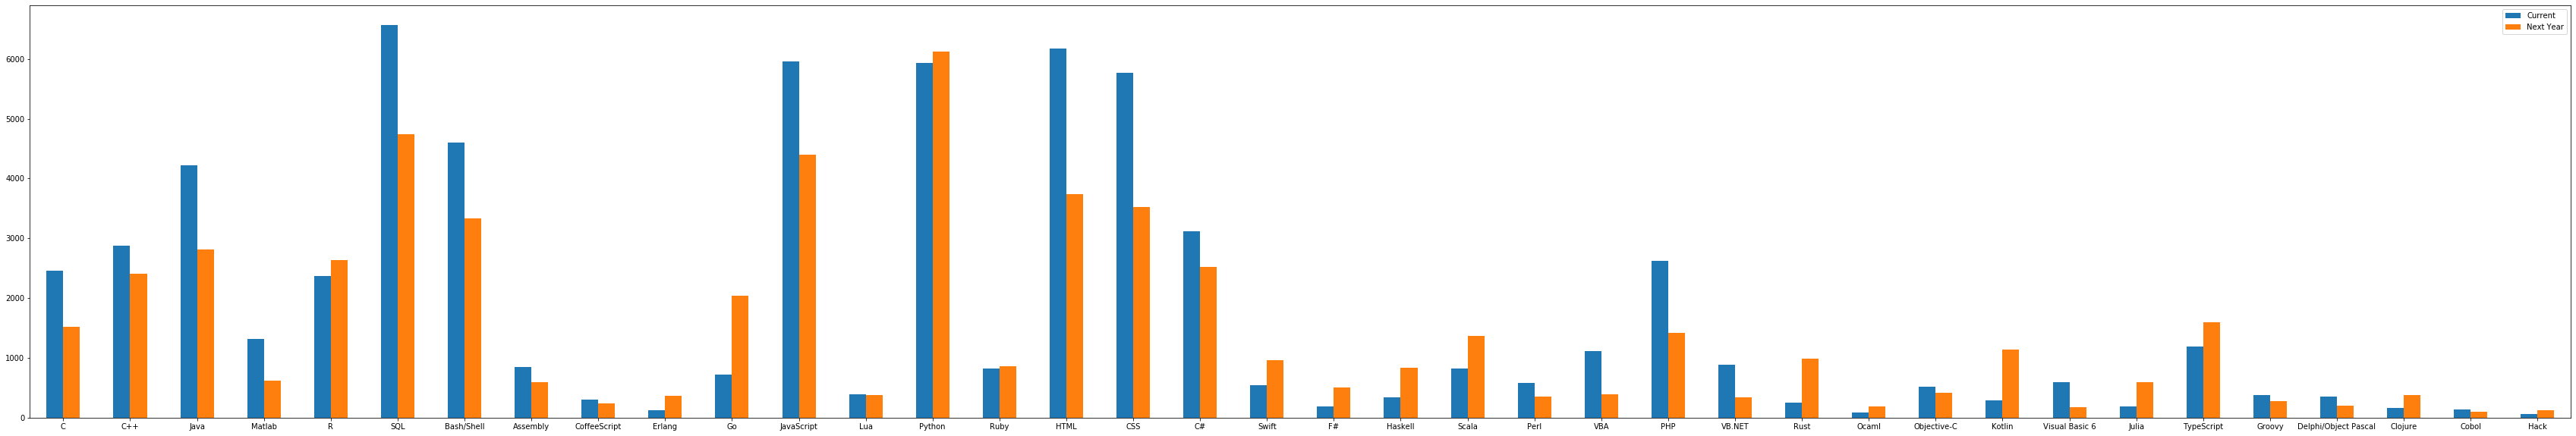

In [84]:
dict_languages_current_next_ds = {"Current" : languages_all_this_ds , "Next Year" : languages_all_next_ds}
languages_dataframe_ds = pd.DataFrame(dict_languages_current_next_ds)
languages_plot_ds = languages_dataframe_ds.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
fig = plt.gcf()
fig.set_size_inches(60, 10) 
plt.savefig("./Figure/Languages_this_next_ds.png")
plt.show()

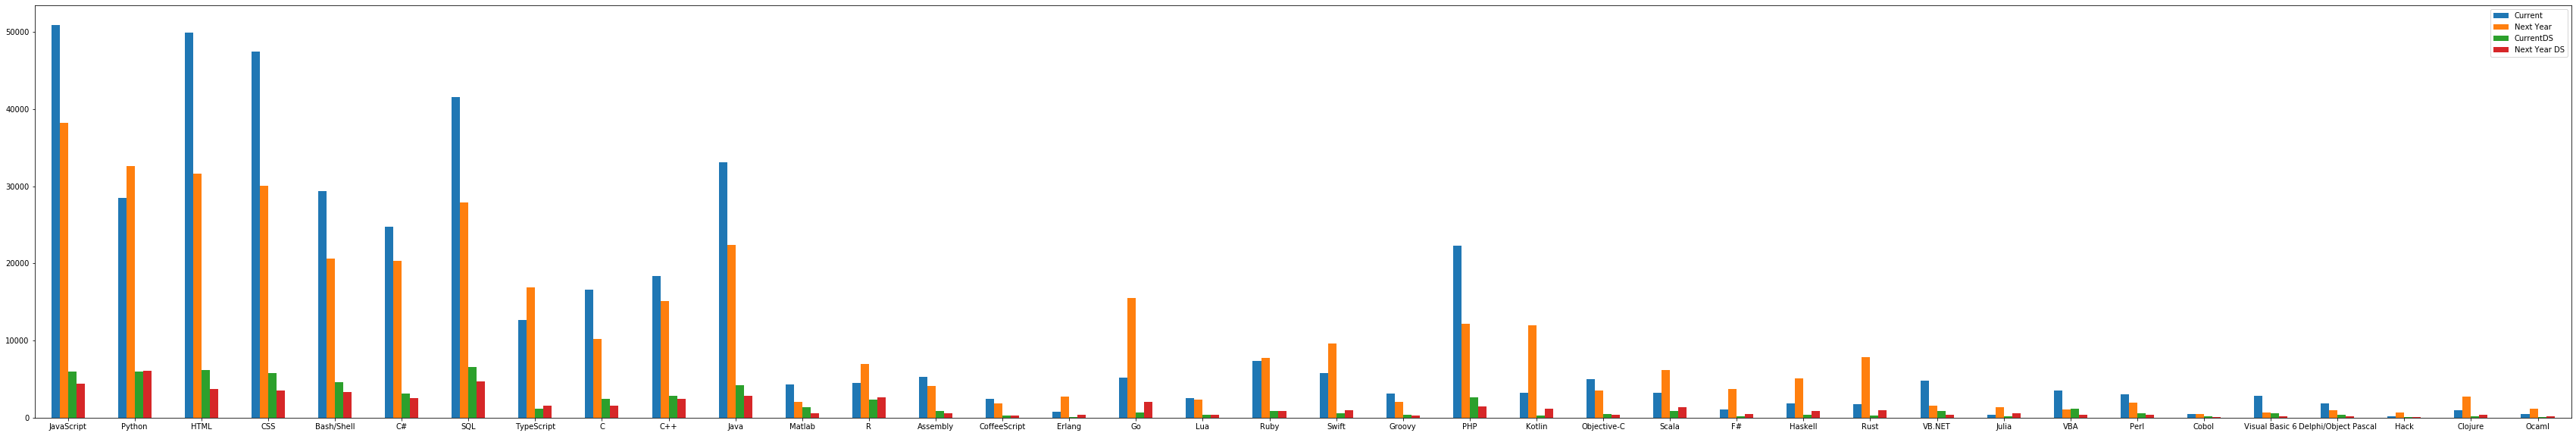

In [85]:
dict_languages_current_next_ds_merge = {"Current" : languages_all_this , "Next Year" : languages_all_next , "CurrentDS" : languages_all_this_ds , "Next Year DS" : languages_all_next_ds}
languages_dataframe_ds_merge = pd.DataFrame(dict_languages_current_next_ds_merge)
languages_plot_ds = languages_dataframe_ds_merge.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
fig = plt.gcf()
fig.set_size_inches(60, 10) 
plt.savefig("./Figure/Languages_this_next_ds_merge.png")
plt.show()

---
## Platform 
+ platform desire next year

In [93]:
def query_platforms_experience():
    query_sql = "SELECT platformworkedwith, platformdesirenextyear from " + main_table + " WHERE platformworkedwith is not null AND platformdesirenextyear is not null"
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall()
    query_sql_ds = "SELECT platformworkedwith, platformdesirenextyear, devtype from " + main_table + " WHERE platformworkedwith is not null AND platformdesirenextyear is not null AND devtype is not null"
    c = conn.cursor()
    c.execute(query_sql_ds)
    conn.commit()
    rows_ds  = c.fetchall()
    
    return rows, rows_ds
queried_platform, queried_platform_ds = query_platforms_experience()
queried_platforms_this_next = pd.DataFrame(queried_platform , columns = ["PlatformsCurrent" , "PlatformsNext"])
queried_platforms_this_next_ds = pd.DataFrame(queried_platform_ds , columns = ["PlatformsCurrent" , "PlatformsNext", "DevType"])

In [96]:
def find_platforms_all():
    platforms_current = {}
    platforms_next = {}
    platforms_current_ds = {}
    platforms_next_ds = {}
    for i in queried_platforms_this_next_ds.values: 
        if i is not None and i[0] is not None and i[1] is not None:
            jobs_titles = i[2].split(";")  
            
            this_man_is_ds = False
            # Check if job is data scientist
            for job_indi in jobs_titles:
                if job_indi in data_science_position_titles:
                    this_man_is_ds = True
                     
            current_list = i[0].split(";") 
            next_list = i[1].split(";")
            for platforms_current_indi in current_list:
                try:
                    platforms_current[platforms_current_indi] +=1
                    if this_man_is_ds:
                        platforms_current_ds[platforms_current_indi] +=1
                except:
                    platforms_current[platforms_current_indi] = 1
                    if this_man_is_ds:
                        platforms_current_ds[platforms_current_indi] = 1 
            for platforms_next_indi in next_list:
                try:
                    platforms_next[platforms_next_indi] +=1
                    if this_man_is_ds:
                        platforms_next_ds[platforms_next_indi] +=1
                except:
                    platforms_next[platforms_next_indi] = 1
                    if this_man_is_ds:
                        platforms_next_ds[platforms_next_indi] = 1
             
                
                
    return platforms_current, platforms_next , platforms_current_ds, platforms_next_ds 
platforms_current , platforms_next, platforms_current_ds, platforms_next_ds  = find_platforms_all()

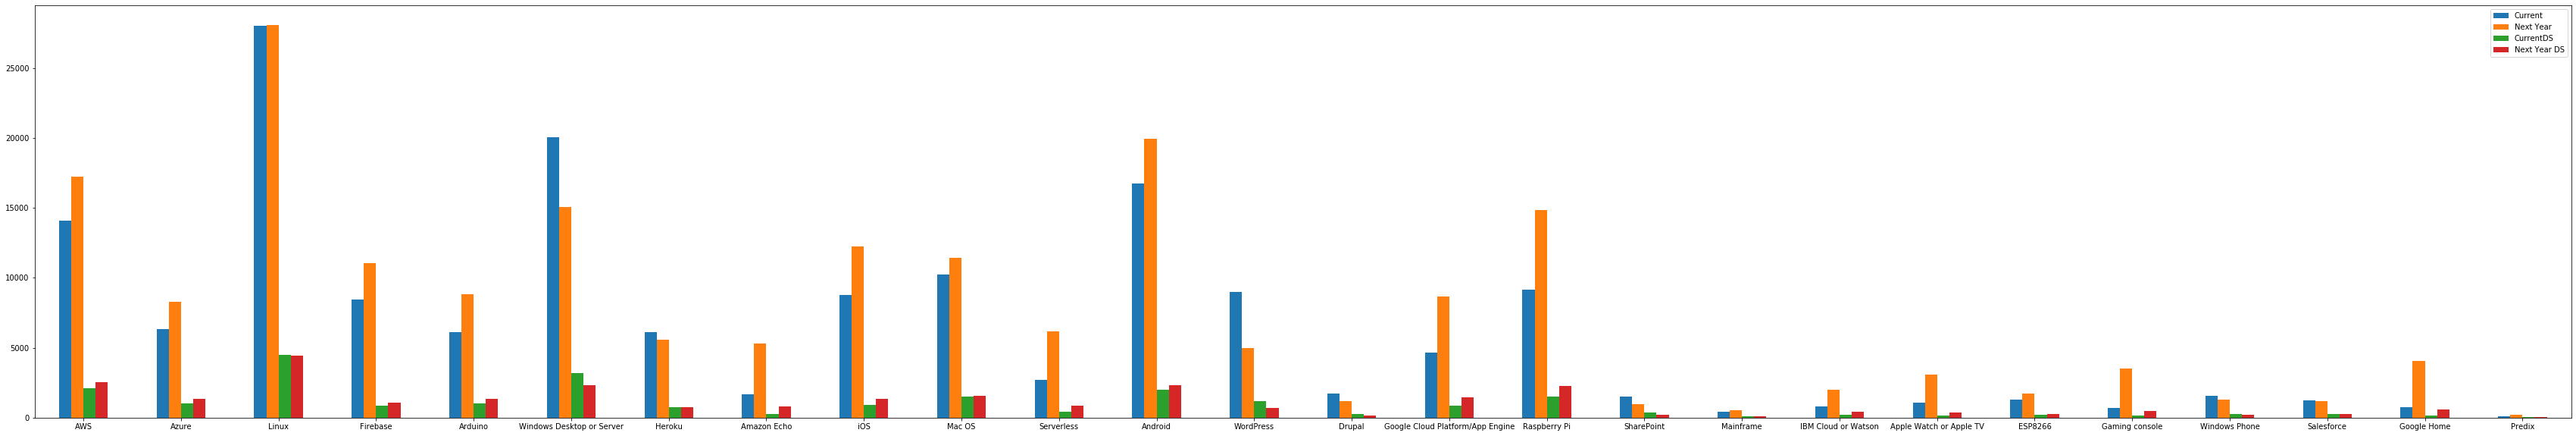

In [101]:
# Overall normal + DS
dict_platforms_count = {"Current" : platforms_current , "Next Year" : platforms_next , "CurrentDS" : platforms_current_ds , "Next Year DS" : platforms_next_ds}
dict_platforms_count_df = pd.DataFrame(dict_platforms_count)
dict_platforms_count_df_plot = dict_platforms_count_df.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
fig = plt.gcf()
fig.set_size_inches(60, 10) 
plt.savefig("./Figure/platform_merge.png")
plt.show()

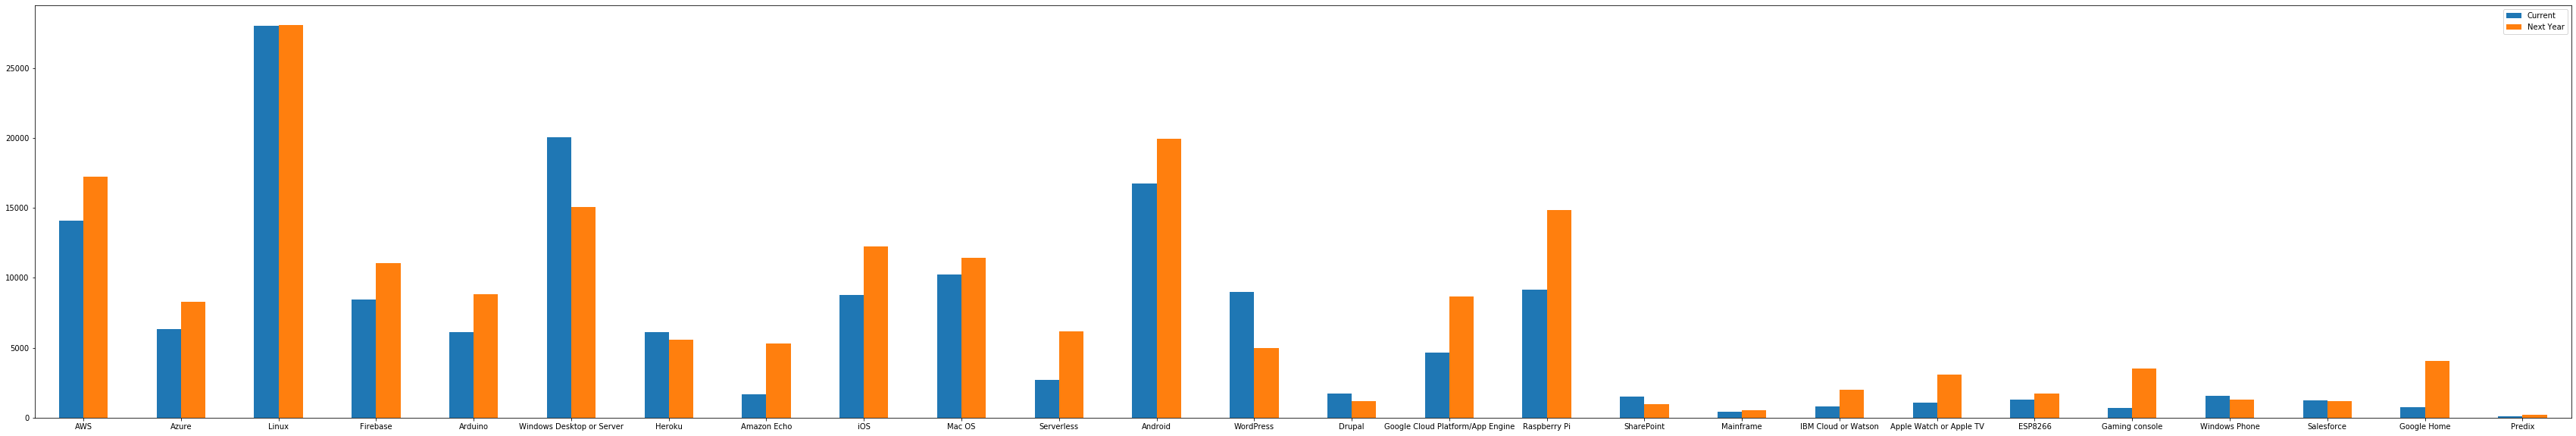

In [102]:
# Overall normal 
dict_platforms_count_normal = {"Current" : platforms_current , "Next Year" : platforms_next }
dict_platforms_count_normal_df = pd.DataFrame(dict_platforms_count_normal)
dict_platforms_count_df_normal_plot = dict_platforms_count_normal_df.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
fig = plt.gcf()
fig.set_size_inches(60, 10) 
plt.savefig("./Figure/platform_normal.png")
plt.show()

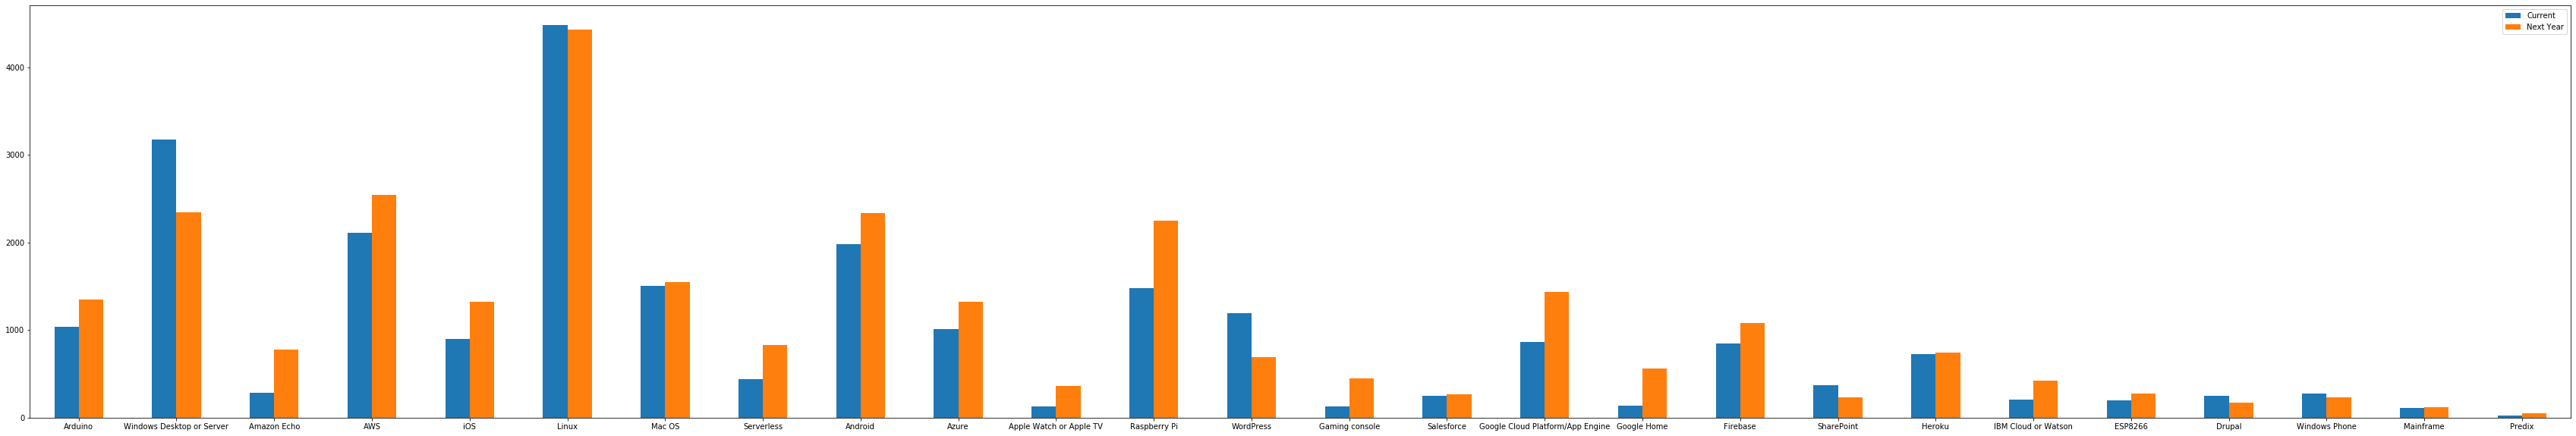

In [106]:
# Overall normal + DS
dict_platforms_count_ds = {"Current" : platforms_current_ds , "Next Year" : platforms_next_ds }
dict_platforms_count_ds_df = pd.DataFrame(dict_platforms_count_ds)
dict_platforms_count_df_ds_plot = dict_platforms_count_ds_df.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
fig = plt.gcf()
fig.set_size_inches(60, 10) 
plt.savefig("./Figure/platform_ds.png")
plt.show()

---
## IDE


In [109]:
def query_ide():
    query_sql = "SELECT ide, devtype from " + main_table + " WHERE ide is not null AND devtype is not null"
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall() 
    
    return rows  
queried_ide = pd.DataFrame(query_ide() , columns = ["IDE" , "DevType"])

In [110]:
def find_ide_count():
    ide = {}
    ide_ds = {} 
    for i in queried_ide.values: 
        if i is not None and i[0] is not None and i[1] is not None:
            jobs_titles = i[1].split(";")  
            
            this_man_is_ds = False
            # Check if job is data scientist
            for job_indi in jobs_titles:
                if job_indi in data_science_position_titles:
                    this_man_is_ds = True
                     
            current_list = i[0].split(";")  
            for ide_indi in current_list:
                try:
                    ide[ide_indi] +=1
                    if this_man_is_ds:
                        ide_ds[ide_indi] +=1
                except:
                    ide[ide_indi] = 1
                    if this_man_is_ds:
                        ide_ds[ide_indi] = 1   
    return  ide , ide_ds 
ide , ide_ds = find_ide_count()

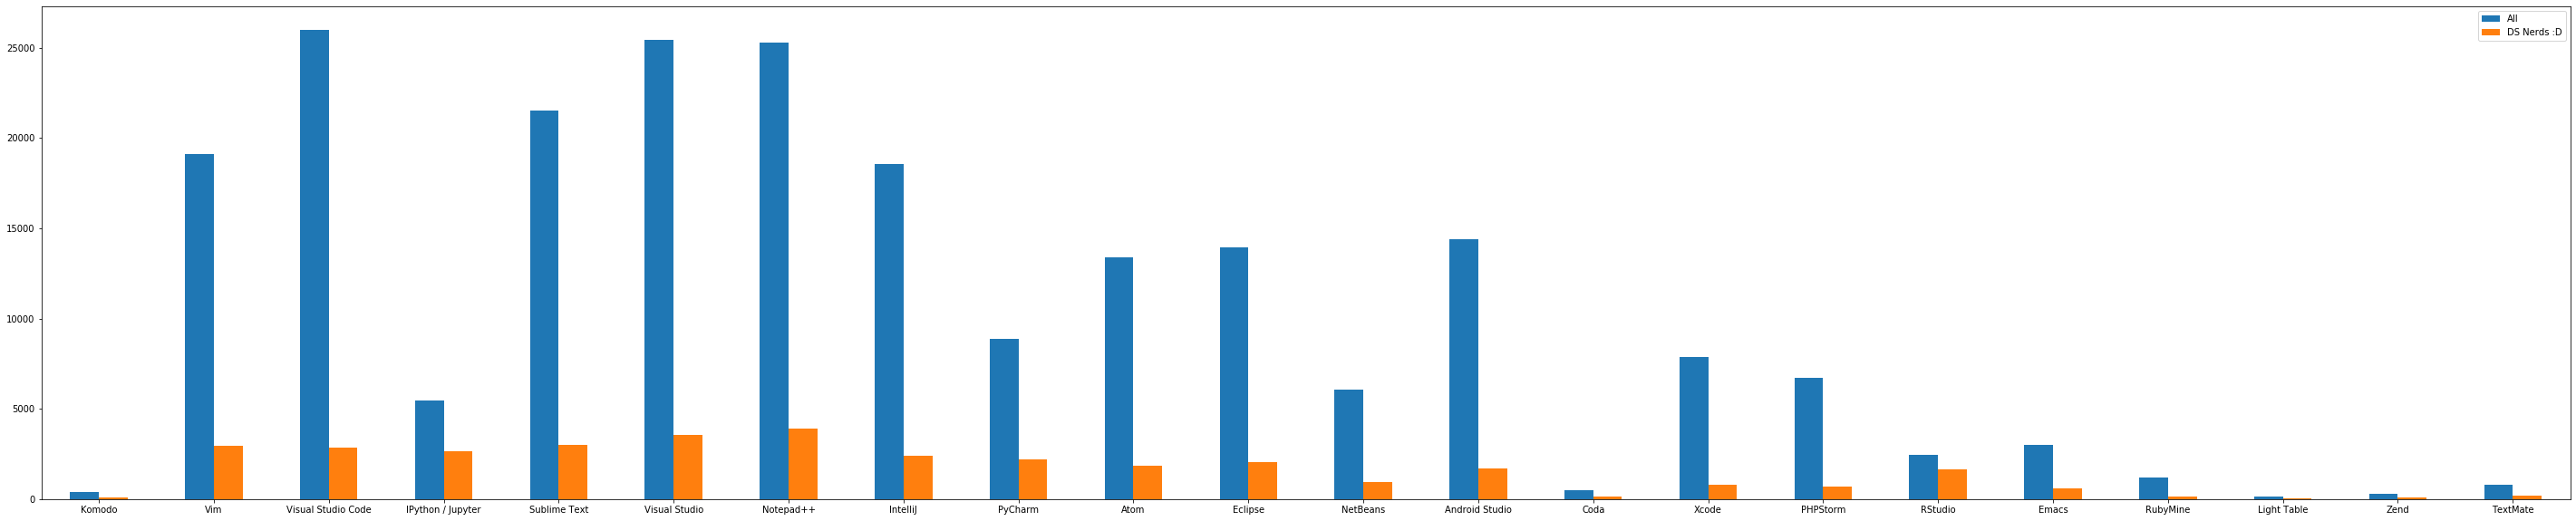

In [113]:
# Overall normal 
dict_ids_count = {"All" : ide , "DS Nerds :D" : ide_ds }
dict_ids_count_df = pd.DataFrame(dict_ids_count)
dict_ids_count_df_plot = dict_ids_count_df.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
fig = plt.gcf()
fig.set_size_inches(50, 10) 
plt.savefig("./Figure/ide_choices.png")
plt.show()

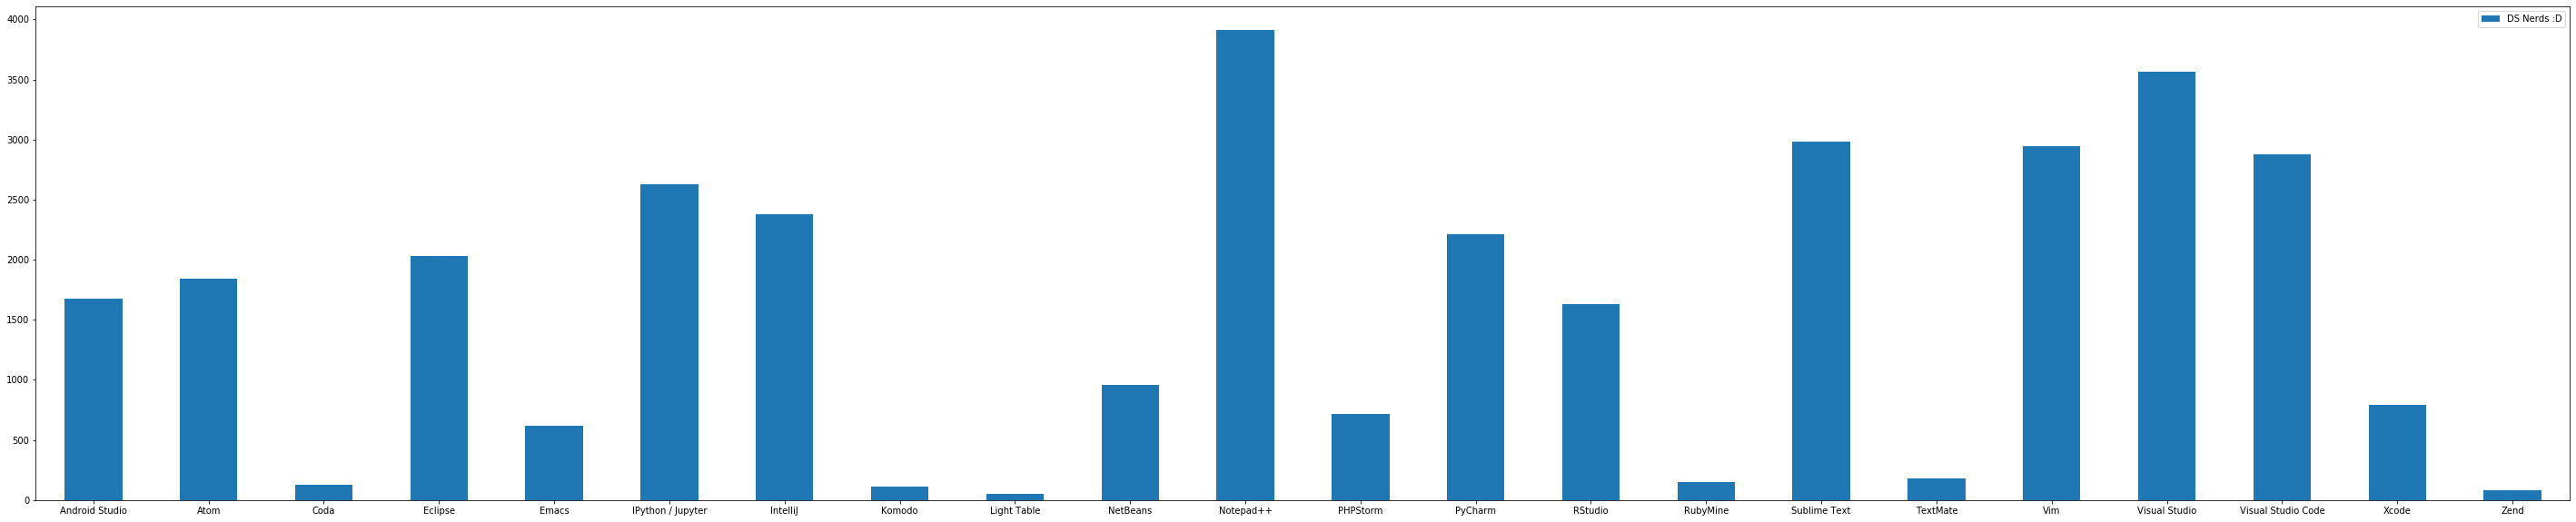

In [117]:
# Overall normal 
dict_ids_count = { "DS Nerds :D" : ide_ds }
dict_ids_count_df = pd.DataFrame(dict_ids_count)
dict_ids_count_df_plot = dict_ids_count_df.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
fig = plt.gcf()
fig.set_size_inches(50, 10) 
plt.savefig("./Figure/ide_choices_ds.png")
plt.show()

---
## Operating System - Data Scientist
## Operating System - Software Developer

In [118]:
def query_os():
    query_sql = "SELECT operatingsystem, devtype from " + main_table + " WHERE operatingsystem is not null AND devtype is not null"
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall() 
    
    return rows  
queried_os = pd.DataFrame(query_os() , columns = ["IDE" , "DevType"])

In [119]:
def find_os_count():
    os = {}
    os_ds = {} 
    for i in queried_os.values: 
        if i is not None and i[0] is not None and i[1] is not None:
            jobs_titles = i[1].split(";")  
            
            this_man_is_ds = False
            # Check if job is data scientist
            for job_indi in jobs_titles:
                if job_indi in data_science_position_titles:
                    this_man_is_ds = True
                     
            current_list = i[0].split(";")  
            for os_options in current_list:
                try:
                    os[os_options] +=1
                    if this_man_is_ds:
                        os_ds[os_options] +=1
                except:
                    os[os_options] = 1
                    if this_man_is_ds:
                        os_ds[os_options] = 1   
    return os , os_ds 
os , os_ds =  find_os_count()

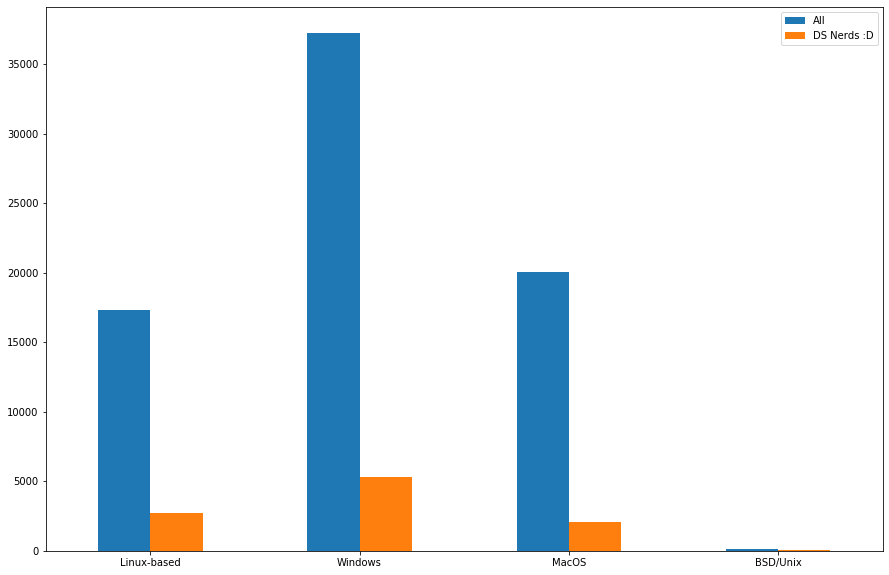

In [122]:
# Overall normal 
dict_os_count = {"All" : os , "DS Nerds :D" : os_ds }
dict_os_count_df = pd.DataFrame(dict_os_count)
dict_os_count_df_plt = dict_os_count_df.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
fig = plt.gcf()
fig.set_size_inches(15, 10) 
plt.savefig("./Figure/os.png")
plt.show()

In [123]:
os_ds

{'Windows': 5325, 'MacOS': 2095, 'BSD/Unix': 25, 'Linux-based': 2732}

---
## SALARY
- overall salary describe done
- median/ mean done
- countries
- gender done
- devtype
- languages 


In [133]:
def query_salary_respondents():
    query_sql = "SELECT convertedsalary from " + main_table 
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall() 
    none_count = 0
    has_value_count = 0
    for i in rows: 
        if i[0] is None:
            none_count +=1
        else:
            has_value_count+=1 
    return has_value_count / ( none_count + has_value_count)
percentage_salary_respondents = query_salary_respondents()

None 51153
Has 47702


In [137]:
print("Only %1.3f of respondents replied their salary" % ( percentage_salary_respondents))

Only 0.483 of respondents replied their salary


In [159]:
def query_female_salary():
    
    query_sql = "SELECT convertedsalary, gender  from " + main_table + " WHERE gender like 'Female'"
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall() 
    female_salary_list = []
    for i in rows:
        if i[0] is not None:
#             print(float(i[0]))
            female_salary_list.append(float(i[0]))
    return female_salary_list
female_salary = pd.DataFrame(query_female_salary() , columns = ["Female Salary"])
print(female_salary.describe().round())
    

       Female Salary
count         2649.0
mean         88251.0
std         188578.0
min              0.0
25%          23808.0
50%          54336.0
75%          85000.0
max        2000000.0


In [160]:
def query_male_salary():
    
    query_sql = "SELECT convertedsalary, gender  from " + main_table + " WHERE gender like 'Male'"
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall() 
    male_salary_list = []
    for i in rows:
        if i[0] is not None:
#             print(float(i[0]))
            male_salary_list.append(float(i[0]))
    return male_salary_list
male_salary = pd.DataFrame(query_male_salary() , columns = ["Male Salary"])
print(male_salary.describe().round())
    

       Male Salary
count      41232.0
mean       96477.0
std       201243.0
min            0.0
25%        24972.0
50%        56100.0
75%        94842.0
max      2000000.0


In [162]:
def query_all_salary():
    
    query_sql = "SELECT convertedsalary, gender  from " + main_table 
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall() 
    all_salary_list = []
    for i in rows:
        if i[0] is not None:
#             print(float(i[0]))
            all_salary_list.append(float(i[0]))
    return all_salary_list
all_salary = pd.DataFrame(query_all_salary() , columns = ["All Salary"])
print(all_salary.describe().round())
    

       All Salary
count     47702.0
mean      95781.0
std      202348.0
min           0.0
25%       23844.0
50%       55075.0
75%       93000.0
max     2000000.0


In [198]:
def query_salary():
    query_sql = "SELECT convertedsalary, devtype, country  from " + main_table + " WHERE convertedsalary is not null AND country is not null and devtype is not null"
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall()  
    return rows  

queried_salary = pd.DataFrame(query_salary() , columns = ["Salary", "DevType", "Country"])

In [207]:
country_salary_dict = {}
country_salary_dict_ds = {} 
for i in queried_salary.values:
#     print(i)
#     new_i = i[0]
#     print(new_i)
    
    #Check if DS
    this_man_is_ds = False
    jobs_split = i[1].split(";")
    for q in jobs_split:
        if q in data_science_position_titles:
            this_man_is_ds = True
    
    if i[0] is not None:
        salary_int_value = round(float(i[0]))
        try:
            country_salary_dict[i[2]].append(salary_int_value)
            if this_man_is_ds:
                country_salary_dict_ds[i[2]].append(salary_int_value) 
        except:
            country_salary_dict[i[2]] = [] 
            country_salary_dict[i[2]].append(salary_int_value) 
            if this_man_is_ds:
                country_salary_dict_ds[i[2]] = []
                country_salary_dict_ds[i[2]].append(salary_int_value) 
#     print(country_salary_dict)
#     print(country_salary_dict_ds) 


In [222]:
new_country_salary_mean_dict = {}
for i in country_salary_dict.values():
    print(statistics.median(i))
    print(statistics.mean(i))
    break

62507.0
128122.63779317697


In [ ]:
def find_salary_report():
    